In [1]:
from google.colab import files
uploaded=files.upload()

Saving HDFCBANK.BO.csv to HDFCBANK.BO.csv


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Activation
from keras.callbacks import EarlyStopping
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import time
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [25]:
df=pd.read_csv("HDFCBANK.BO.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-04-01,533.0,536.500000,528.500000,532.500000,516.979248,75410.0
1,2016-04-04,534.5,536.224976,532.150024,534.650024,519.066589,70052.0
2,2016-04-05,534.0,538.325012,527.625000,529.150024,513.726807,158490.0
3,2016-04-06,532.5,533.400024,528.349976,530.750000,515.280212,87236.0
4,2016-04-07,535.0,535.500000,523.599976,527.825012,512.440491,79930.0


In [26]:
df.dropna(axis=0, inplace=True)

In [27]:
df1=df["Close"].values

In [28]:
df1=np.reshape(df1, (1231, 1))

In [29]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [30]:
def create_dataset(dataset, lag_var=1):
	datax, datay = [], []
	for i in range(len(dataset)-lag_var-1):
		a = dataset[i:(i+lag_var), 0]   ###i=0,1,2,3,4
		datax.append(a)
		datay.append(dataset[i + lag_var, 0])
	return np.array(datax), np.array(datay)

In [31]:
lag_var=5
X, y = create_dataset(df1, lag_var)

In [32]:
##splitting dataset into train and test split
train_size=int(len(X)*0.75)
test_size=len(X)-train_size
train_X,test_X=X[0:train_size,:],X[train_size:,:]

In [33]:
##splitting dataset into train and valid split
train_size=int(len(train_X)*0.75)
test_size=len(train_X)-train_size
tr_X,valid_X=train_X[0:train_size,:],train_X[train_size:len(train_X),:]

In [34]:
Trn_X =tr_X.reshape(tr_X.shape[0],tr_X.shape[1] , 1)
val_X =valid_X.reshape(valid_X.shape[0],valid_X.shape[1] , 1)

In [35]:
Trn_y=y[0:688]
val_y=y[688:918]

In [36]:
model=Sequential()
model.add(LSTM(10,input_shape=(5,1)))
model.add(Activation('tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='rmsprop')
# simple early stopping
es = EarlyStopping(monitor='val_loss', patience=1, mode='auto', verbose=1, restore_best_weights=True)

In [37]:
begin = time.time()
history = model.fit(Trn_X,Trn_y,validation_data=(val_X,val_y), epochs=1000, verbose=1, callbacks=[es])
time.sleep(1)
# store end time
end = time.time()

Epoch 1/1000
22/22 [==============================] - 3s 27ms/step - loss: 0.0290 - val_loss: 0.0577
Epoch 2/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0078 - val_loss: 0.0198
Epoch 3/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.0043 - val_loss: 0.0098
Epoch 4/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 5/1000
22/22 [==============================] - 0s 5ms/step - loss: 5.2926e-04 - val_loss: 3.6928e-04
Epoch 6/1000
22/22 [==============================] - 0s 6ms/step - loss: 1.6689e-04 - val_loss: 4.8258e-04
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


(array([-0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07]),
 <a list of 9 Text major ticklabel objects>)

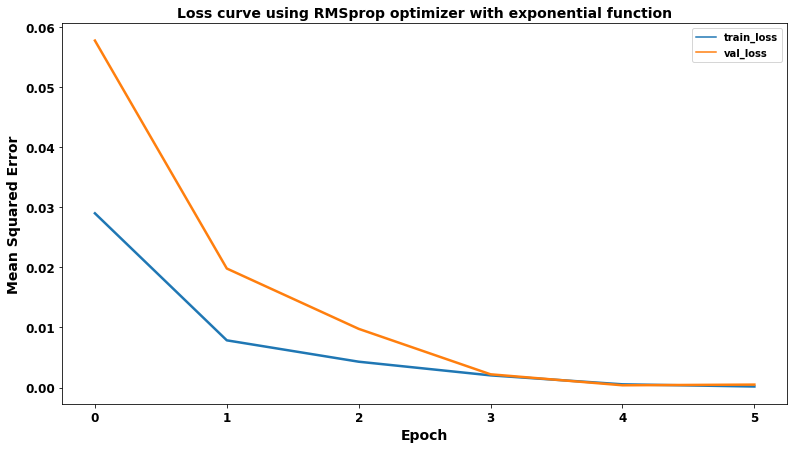

In [38]:
df_loss=pd.DataFrame()
df_loss['train_loss']=history.history['loss']
df_loss['val_loss']=history.history['val_loss']
df_loss.reset_index(inplace=True)
df_loss = df_loss.rename(columns = {'index':'Epoch'})

legend_properties = {'weight':'bold'}
fig, axes = plt.subplots(figsize=(13,7))
sns.lineplot(x='Epoch', y='value', hue='variable', 
             data=pd.melt(df_loss, ['Epoch']), color='red', linewidth=2.5)
plt.title("Loss curve using RMSprop optimizer with exponential function", fontsize=14, fontweight="bold")
plt.xlabel("Epoch", fontsize=14, fontweight="bold")
plt.ylabel("Mean Squared Error", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.legend(fontsize=12, prop=legend_properties)
plt.yticks(fontsize=12, fontweight="bold")
#plt.savefig("loss_rmsprop_exponential.jpg")

In [39]:
tst_X =test_X.reshape(test_X.shape[0],test_X.shape[1] , 1)
X_trans=X.reshape(X.shape[0],X.shape[1] , 1)
tst_predict=model.predict(tst_X)
X_pred=model.predict(X_trans)

In [40]:
test_predict=scaler.inverse_transform(tst_predict)
X_predict=scaler.inverse_transform(X_pred)
y_original=scaler.inverse_transform(y.reshape(-1,1))

In [41]:
#mape test
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(y_original, X_predict)

1.773272522415673

In [42]:
#mape test
mean_absolute_percentage_error(y_original[918:],test_predict)

2.538520395761583

In [43]:
#mape val
mean_absolute_percentage_error(y_original[688:918],X_predict[688:918])

1.227299026551455

In [44]:
#mape train
mean_absolute_percentage_error(y_original[:688],X_predict[:688])

1.6143231271896274

In [45]:
#rmse full
math.sqrt(mean_squared_error(y_original, X_predict))

24.19386359674078

In [46]:
#rmse test
math.sqrt(mean_squared_error(y_original[918:],test_predict))

38.63244590937052

In [47]:
#rmse val
math.sqrt(mean_squared_error(y_original[688:918],X_predict[688:918]))

21.11490792500246

In [48]:
#rmse train
math.sqrt(mean_squared_error(y_original[:688],X_predict[:688]))

15.073230239581878

In [49]:
#r2 full
r2_score(y_original,X_predict)

0.9903777299082963

In [50]:
#r2 test
r2_score(y_original[918:],test_predict)

0.9674940058642444

In [51]:
#r2 val
r2_score(y_original[688:918],X_predict[688:918])

0.9176281298121718

In [52]:
#r2 train
r2_score(y_original[:688],X_predict[:688])

0.992397363221372

In [53]:
df['Date']=pd.to_datetime(df["Date"])
df["month_year"]=df["Date"].dt.strftime('%Y-%m')
dates=df["month_year"].iloc[5:1230].values

In [54]:
final=pd.DataFrame()

In [55]:
final['real']=np.reshape(y_original, (1225,))
final['predicted']=np.reshape(X_predict, (1225,))
final['date']=dates

(array([ 400.,  600.,  800., 1000., 1200., 1400., 1600., 1800.]),
 <a list of 8 Text major ticklabel objects>)

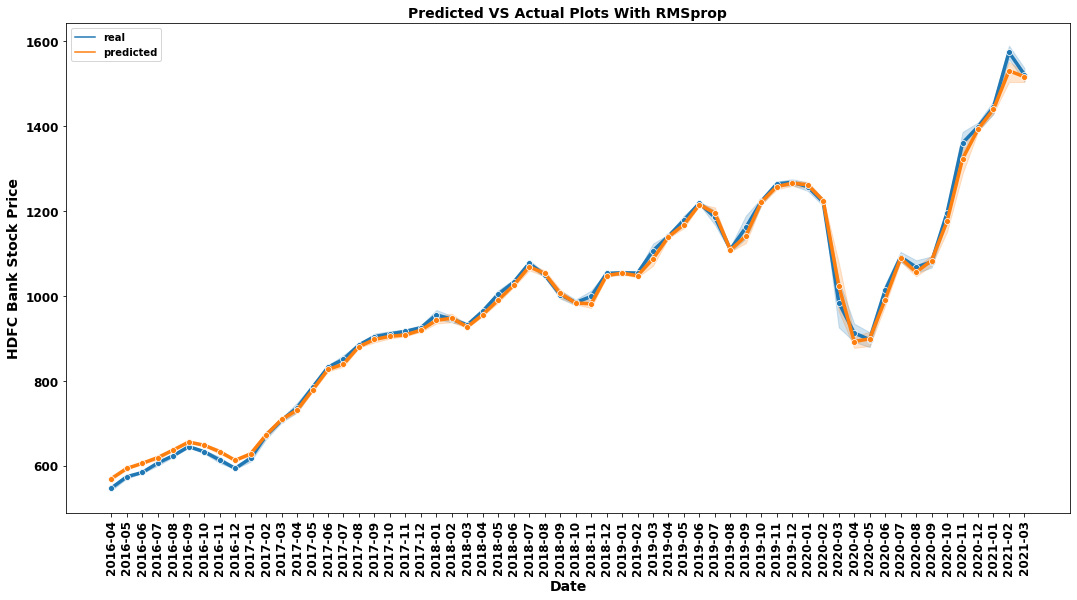

In [56]:
legend_properties = {'weight':'bold'}
fig, axes = plt.subplots(figsize=(18,9))
sns.lineplot(x='date', y='value', hue='variable', 
             data=pd.melt(final, ['date']), linewidth=3.5, marker = 'o')
plt.title("Predicted VS Actual Plots With RMSprop", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=14, fontweight="bold")
plt.ylabel("HDFC Bank Stock Price", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12, rotation = 'vertical', fontweight="bold")
plt.legend(fontsize=12, prop=legend_properties)
plt.yticks(fontsize=12, fontweight="bold")
#plt.savefig("predicted_plot_adam_lag5.jpg")

No handles with labels found to put in legend.


(array([ 400.,  600.,  800., 1000., 1200., 1400., 1600., 1800.]),
 <a list of 8 Text major ticklabel objects>)

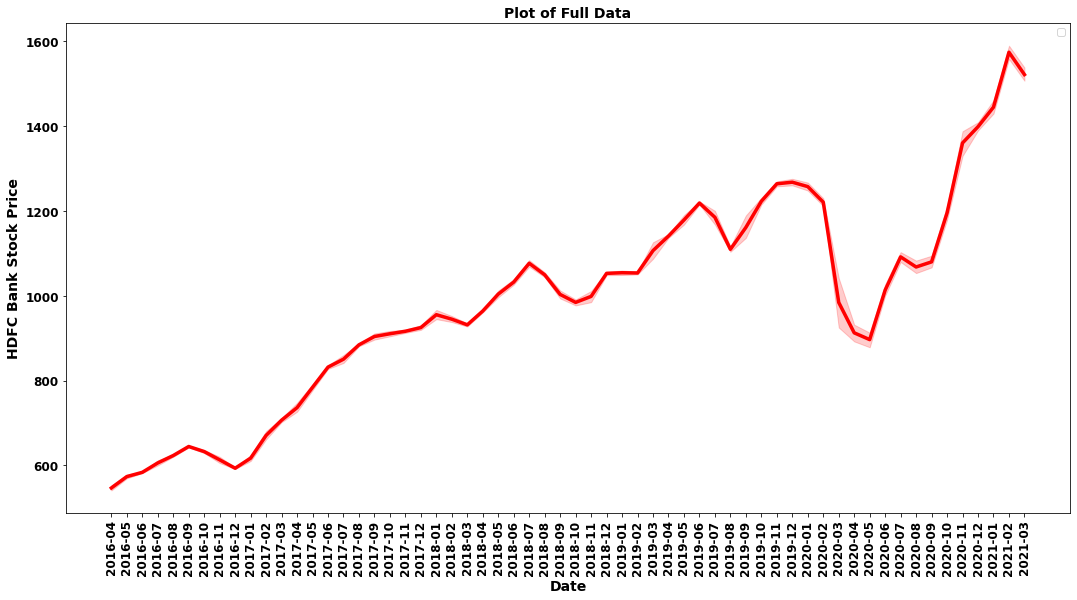

In [57]:
legend_properties = {'weight':'bold'}
fig, axes = plt.subplots(figsize=(18,9))
sns.lineplot(x='date', y='real', data=final, linewidth=3.5, Color='red')
plt.title("Plot of Full Data", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=14, fontweight="bold")
plt.ylabel("HDFC Bank Stock Price", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12, rotation = 'vertical', fontweight="bold")
plt.legend(fontsize=12, prop=legend_properties)
plt.yticks(fontsize=12, fontweight="bold")
#plt.savefig("lineplot_full_data_new.jpg")